![Image Description](McGill.png)


In [51]:
import h5py
import numpy as np
import glob 
import os
import matplotlib.pyplot as plt
import pandas as pd
datadir = '/nfsscratch/Users/wndrsn/atl02'

# Noisy Night Time Data

Text(0.5, 1.0, 'Night_data')

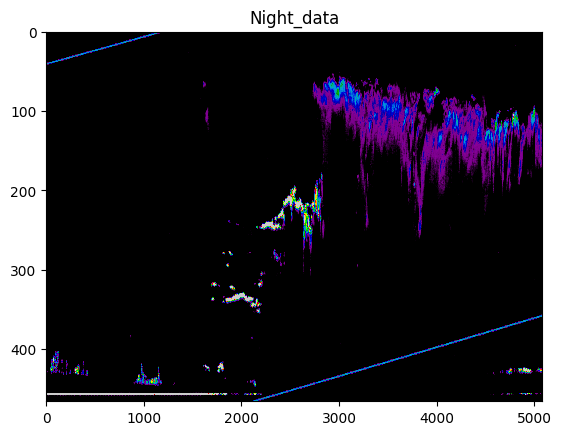

In [52]:
def get_atm_bins_mybackg(file):
    with h5py.File(file, 'r') as data:
        atm = {k: np.array(data[f'/atlas/pce1/atmosphere_s/{k}']) for k in data['/atlas/pce1/atmosphere_s'].keys()}
        atm_bins = atm['atm_bins']
        bg = atm_bins.mean(axis=1, keepdims=True)
        atm_bins_mybackg = atm_bins-bg
        return atm_bins_mybackg
    
def getBinsloud(file):
    with h5py.File(file, 'r') as data:
        atm = {k: np.array(data[f'/atlas/pce1/atmosphere_s/{k}']) for k in data['/atlas/pce1/atmosphere_s'].keys()}
        atm_bins = atm['atm_bins']
        return atm_bins
    
def make_noisy(df,noise_level):
    noise_level = noise_level*100
    noisy_bg = np.full_like(df, noise_level)

    noisy_dataset = df + noisy_bg

    noisy = np.random.poisson(np.maximum(noisy_dataset, 0))
    
    return noisy

# First subplot
datadir = '/nfsscratch/Users/wndrsn/atl02'
files = sorted(glob.glob(os.path.join(datadir, f'**/*.h5'), recursive=True))[2]
raw_night_dataset = getBinsloud(files)
night_dataset_im = get_atm_bins_mybackg(files)
plt.imshow(night_dataset_im.T, aspect='auto', cmap='nipy_spectral', vmin=0, vmax=50)
plt.title('Night_data')

# Day Time Data

-854.2912205567452 5615.089935760171 -8.283710927010696e-17


Text(0.5, 1.0, 'Day Time Data With Background Subtraction')

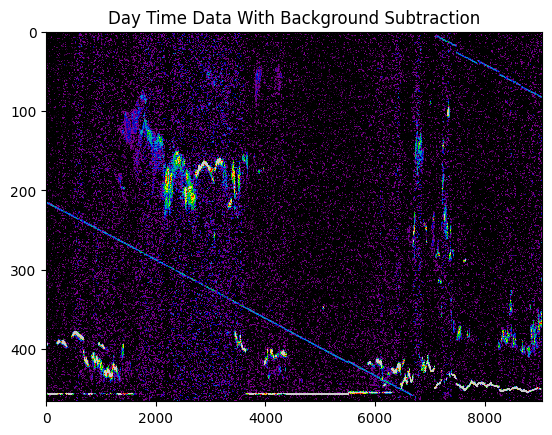

In [53]:
savedir = '/nfsscratch/Users/wndrsn/atl02'  # Replace with the actual save directory path
file = sorted(glob.glob(os.path.join(datadir, f'**/*.h5'), recursive=True))[90]
raw_solar_dataset = getBinsloud(file)
solar_dataset = get_atm_bins_mybackg(file) 
print(solar_dataset.min(),solar_dataset.max(),solar_dataset.mean())
plt.imshow(solar_dataset.T, aspect='auto', cmap='nipy_spectral', vmin=0, vmax=50)
plt.title('Day Time Data With Background Subtraction')

# Difference in scale seems to be causing issues with learning algorithm
- Night time data is exponentially less loud
- Algorithm keeps generating negative psnr values
- Current results only denoise created data
- Algorithm is not aggressive enough as a result and does not work with real data

# Scaling issues can be fixed using multiplication before feeding into algorithm
- Fixed main issues, more fine tuning needed

min = -133.20687880422872 max = 5742.793121195771 mean = -2.1867114727286776e-14


Text(0.5, 1.0, 'Simulated Noisy Image With Scaling')

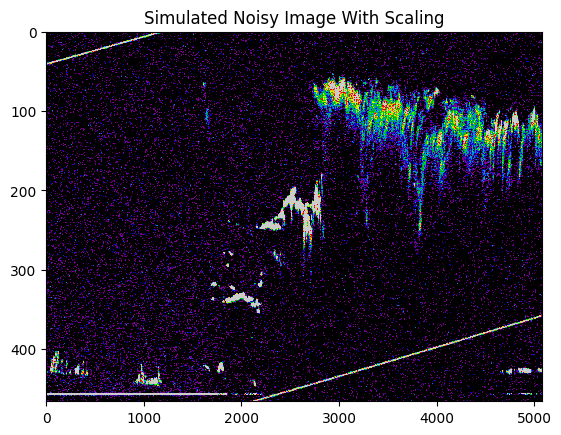

In [54]:
import os
import glob
import matplotlib.pyplot as plt

import numpy as np


# First subplot
datadir = '/nfsscratch/Users/wndrsn/atl02'
files = sorted(glob.glob(os.path.join(datadir, f'**/*.h5'), recursive=True))[2]
dataset = make_noisy(raw_night_dataset*4,8) 
dataset = dataset - dataset.mean()

print('min =',dataset.min(),'max =',dataset.max(),'mean =',dataset.mean())
plt.imshow(dataset.T, aspect='auto', cmap='nipy_spectral', vmin=0, vmax=50)
plt.title('Simulated Noisy Image With Scaling')   

In [55]:
summary_df = pd.DataFrame({
    'Dataset': ['Raw Night','Raw Day','Simulated Noisy Day Time Data', 'Solar-bg','Day v Simulated Data X larger'],
    'Min': [raw_night_dataset.min(), raw_solar_dataset.min(),dataset.min(),solar_dataset.min(),solar_dataset.min()/dataset.min()],
    'Max': [raw_night_dataset.max(), raw_solar_dataset.max(),dataset.max(),solar_dataset.max(),solar_dataset.max()/dataset.max()],
    'Mean': [raw_night_dataset.mean(), raw_solar_dataset.mean(),dataset.mean(),solar_dataset.mean(),solar_dataset.mean()/dataset.mean()]
    
})
display(summary_df)
summary_df.to_csv('dataset_breakdown.csv')

,Dataset,Min,Max,Mean
0,Raw Night,0.000000,1433.000000,1.806069e+00
1,Raw Day,48.000000,5885.000000,5.008393e+02
2,Simulated Noisy Day Time Data,-133.206879,5742.793121,-2.186711e-14
3,Solar-bg,-854.291221,5615.089936,-8.283711e-17
4,Day v Simulated Data X larger,6.413267,0.977763,3.788205e-03


# Distribution of data after background subtraction leads to "negative" photon counts
- Negative photon counts are impossible, therefore we can assume it is background
- Selecting the values < 1 confirms it is mostly background
- Objects we are looking for are not selected

min: -854.2912205567452 max: -0.0021413276231214695


Text(0.5, 1.0, 'Negative Value Mask of Real Day Time Data')

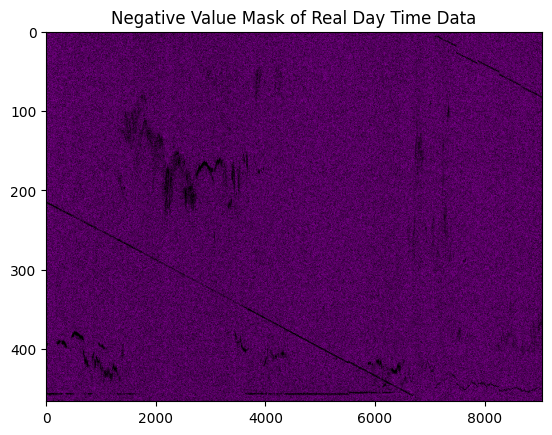

In [56]:
solar_dataset_filter1 = solar_dataset < 0
print('min:',solar_dataset[solar_dataset_filter1].min(),'max:',solar_dataset[solar_dataset_filter1].max())
plt.imshow(solar_dataset_filter1.T, aspect='auto', cmap='nipy_spectral', vmin=0, vmax=15)
plt.title('Negative Value Mask of Real Day Time Data')

# Selecting the values > 1 seems to select mainly the objects we want to focus on

-0.4725839081003703 0.5274160918996297


Text(0.5, 1.0, 'Positive Value Mask of Real Day Time Data')

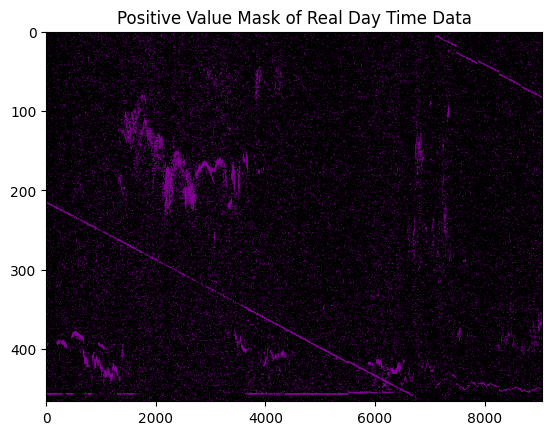

In [57]:
solar_dataset_filter2 = solar_dataset > 0
solar_dataset_filter2 = solar_dataset_filter2-solar_dataset_filter2.mean()
print(solar_dataset_filter2.min(),solar_dataset_filter2.max())
plt.imshow(solar_dataset_filter2.T, aspect='auto', cmap='nipy_spectral', vmin=0, vmax=5)
plt.title('Positive Value Mask of Real Day Time Data')

# Use Background Substract with negative value mask

-854.2912205567452 5615.089935760171 -8.283710927010696e-17
-872.4807807821578 5601.084703951139 -8.831530208826251


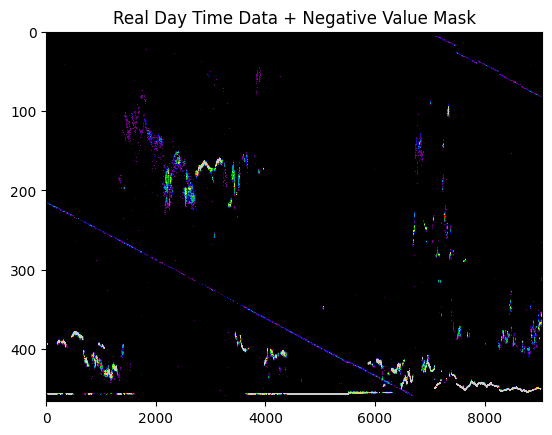

In [58]:
from sklearn import preprocessing as p 
 
bg_wt = np.where(solar_dataset>0, solar_dataset, 0)
data = solar_dataset - bg_wt.mean(axis=1, keepdims=True)
print(solar_dataset.min(),solar_dataset.max(),solar_dataset.mean())
print(data.min(),data.max(),data.mean())
# min_max_scaler = p.MinMaxScaler(feature_range=(0,data.max())) 
# normalizedData = min_max_scaler.fit_transform(data)
plt.title('Real Day Time Data + Negative Value Mask')
plt.imshow((data).T, aspect='auto', cmap='nipy_spectral',vmin = 0,vmax = 50)

# Poisosn Denoising CNN
- Seems to be doubling certain aspects

-124.28365101954665 3458.0803883808926


Text(0.5, 1.0, 'Denoised(rho=7)')

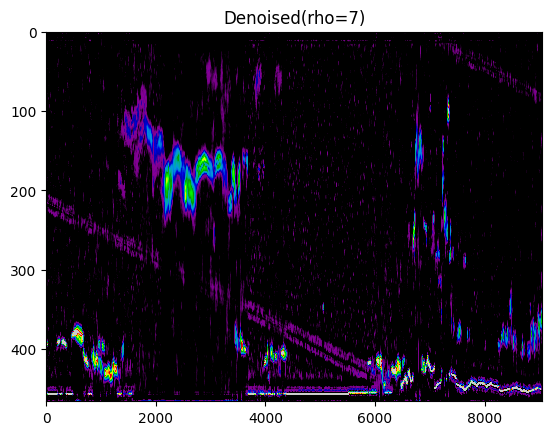

In [59]:
dataset = np.load('test7.05.npy')
print(dataset.min(),dataset.max())
plt.imshow(dataset.T, aspect='auto', cmap='nipy_spectral',vmin=0,vmax = 50)
plt.title('Denoised(rho=7)')

# Poisson Denoising(Rho = 6.999) and Background Subtraction

-170.26966789653125 3435.601559336676


Text(0.5, 1.0, 'Denoised(rho=6.999) + bg(<1).mean')

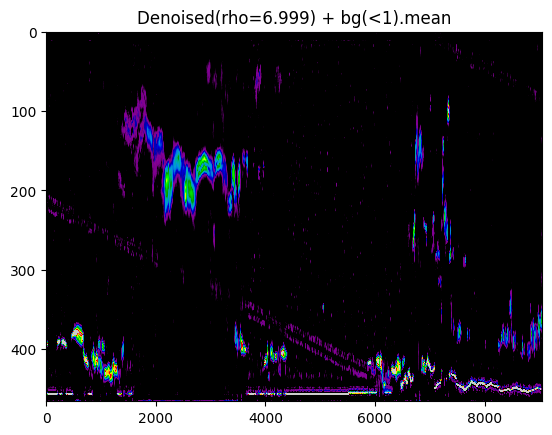

In [60]:
dataset = np.load('/Users/wndrsn/Denoised_Images/psnr6.99999843.npy')
# newset = dataset - dataset.mean(axis=1, keepdims=True) 
newset = dataset 
dataset1_filter = dataset < 1 
newset = dataset + dataset[dataset1_filter].mean()/2 
print(newset.min(),newset.max())
plt.imshow(newset.T, aspect='auto', cmap='nipy_spectral',vmin=0,vmax = 50)
plt.title('Denoised(rho=6.999) + bg(<1).mean')

- Why does this clear up the image but hardly effect the distribution of the data? 
- How can we reset the index to be only positive values? 

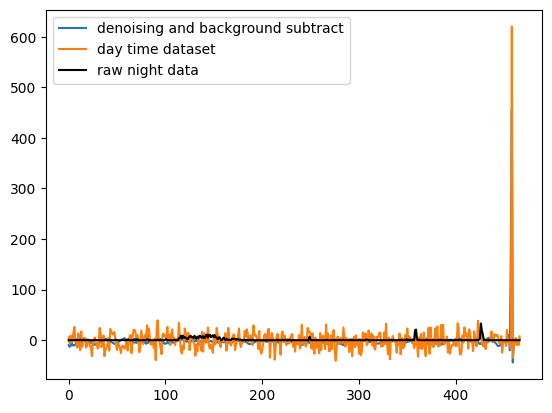

In [61]:
plt.plot(newset[5079], label='denoising and background subtract')
plt.plot(solar_dataset[5079], label='day time dataset')
plt.plot(raw_night_dataset[5079], label='raw night data',color = 'black')

plt.legend(loc='best')

In [62]:
import pandas as pd
import folium
from folium.plugins import HeatMap

# Load the dataset
dataset = pd.read_csv('Collocations_pyorbitals.csv', usecols=['CALIPSO Latitude', 'CALIPSO Longitude', 'Time0_left'])

# Drop rows with missing values
dataset.dropna(inplace=True)

# Create a map centered at the mean latitude and longitude
center_lat = dataset['CALIPSO Latitude'].mean()
center_lon = dataset['CALIPSO Longitude'].mean()
heatmap_map = folium.Map(location=[center_lat, center_lon], zoom_start=5)

# Convert the DataFrame to list of lists for HeatMap
heat_data = [[row['CALIPSO Latitude'], row['CALIPSO Longitude']] for index, row in dataset.iterrows()]

# Add HeatMap layer to the map
HeatMap(heat_data).add_to(heatmap_map)
display(heatmap_map)
# Save or display the map
heatmap_map.save('heatmap.html')
